# NHL Draft dataset
# Statistical Tests on data from the NHL API
This notebook presents statistical tests performed on the NHL Draft data obtained from NHL Records API. Previous steps included data collection and data cleaning.

### Data collection summary
Dataset generated from a JSON received from the NHL Records API, contains response to the request for all draft records.  

For details, see notebook `notebooks/feature_extraction/nhl_api.ipynb`.

### Data cleanup summary
* fixed capitalizations for Amateur Club Names, Player Names
* fixed inconsistent team names for some Russian Amateur Club Names
    * e.g., 'Ska Leningrad', 'St. Petersburg Ska', 'Ska St. Petersburg', 'Leningrad Ska', 'St. Petersburg Ska St. Petersburg' was replaced with 'Ska'
    * team names fixed only for Ska, Ska2, Cska, and Cska 2
* fixed 2 erratic height values and 3 weight values (replaced with mean)
* fixed inconsistent names for Russian leagues
    * 'Russia', 'RUS', 'RUSSIA', 'RUSSIA-1' were changed to 'Russia'
    * 'RUSSIA-JR.', 'RUSSIA JR. 2' were changed to 'Russia-Jr.'
* removed redundant positions
    * all players who can play center are assumed to be centers
        * C/RW (17 players), C/LW (30 players), F (362 players) = C
    * player who can play both wings are assumed to play the right wing
        * LW/RW (13 players) = RW
    * mixed D positions are assumed to be D
        * LW/D (1 player), D/F (1 player) = D
* filtered columns and renamed them to shorten their labels

* data problems identified but not currently addressed:
    * inconsistencies in some Amateur Club Names (e.g., 'London Knights' and 'London')
    * `pickInRound` appears to have erratic values (will be addressed in this notebook)

* data problems potentially present (not verified)
    * inconsistent names for Russian teams other than CSKA and SKA (those were fixed)

For details, see notebook `notebooks/feature_extraction/nhl_draft_api_cleanup.ipynb`

### Types of Statistical Hypothesis Tests

From [machinelearningmastery.com](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/):

There are hundreds of statistical hypothesis tests available, with multiple types of tests available for a given concern, answers that they give to a question are probabilistic in their nature rather than exact. Some of the commonly used ones in Machine Learning include:

* Normality Tests
    * Shapiro-Wilk Test
    * D’Agostino’s K^2 Test
    * Anderson-Darling Test
* Correlation Tests
    * Pearson’s Correlation Coefficient
    * Spearman’s Rank Correlation
    * Kendall’s Rank Correlation
    * Chi-Squared Test
* Parametric Statistical Hypothesis Tests
    * Student’s t-test
    * Paired Student’s t-test
    * Analysis of Variance Test (ANOVA)
    * Repeated Measures ANOVA Test
* Nonparametric Statistical Hypothesis Tests
    * Mann-Whitney U Test
    * Wilcoxon Signed-Rank Test
    * Kruskal-Wallis H Test
    * Friedman Test

### Characteristics of each test
    
Each test has its application scope, assumptions, and interpretation of results.

_Note_, when it comes to assumptions such as the expected distribution of data or sample size, the results of a given test are likely to degrade gracefully rather than become immediately unusable if an assumption is violated.

### Requirements to data samples

Generally, data samples need to be representative of the domain and large enough to expose their distribution to analysis.

In some cases, the data can be corrected to meet the assumptions, such as correcting a nearly normal distribution to be normal by removing outliers, or using a correction to the degrees of freedom in a statistical test when samples have differing variance, to name two examples.

In the case of NHL Draft dataset, we have complete draft records for 2009-2018 NHL Draft seasons, so these records represent a **full population of players drafted to the NHL from 2009 to 2018.**


## Preparations
### Import dependencies

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from time import time
import sys
import os

In [2]:
os.chdir('Documents/repos/nhl_draft/')
sys.path.append('src/')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 'data',
 'design',
 'main.py',
 'models',
 'notebooks',
 'README.md',
 'requirements.txt',
 'src']

In [3]:
from stests_utils import fit_norm_dist

### Load data
#### NHL Draft data

In [4]:
file = 'data/nhl_api/nhl_draft_all_cleaned.csv'
t = time()
df = pd.read_csv(file)
elapsed = time() - t
print("----- DataFrame with NHL Draft Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with NHL Draft Data loaded
in 0.10 seconds
with 11,587 rows
and 15 columns
-- Column names:
 Index(['name', 'nat', 'dob', 'bp', 'ateam', 'league', 'year', 'dteam',
       'overall', 'removed', 'why', 'height', 'weight', 'pos', 'shoots'],
      dtype='object')


#### NHL Records data: Most Goals in a Single Season by a Rookie

In [5]:
rec_name = 'most-goals-rookie-one-season'
suffix = '_new_cols'
rec_file = 'data/nhl_api/records/records_main.csv'
df_rec = pd.read_csv(rec_file)
mask = df_rec['descriptionKey'] == rec_name
name = df_rec.loc[mask, 'description'].values[0]
print("----- NHL Records\n---", name, '\n')

file = 'data/nhl_api/records/' + \
       rec_name + suffix + '.csv'
t = time()
dfr = pd.read_csv(file)
elapsed = time() - t
print("----- DataFrame with NHL Records Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(dfr.shape[0], dfr.shape[1]) + 
      "\n-- Column names:\n", dfr.columns)

----- NHL Records
--- Most Goals, Rookie, Season 

----- DataFrame with NHL Records Data loaded
in 0.12 seconds
with 3,377 rows
and 59 columns
-- Column names:
 Index(['activePlayer', 'assists', 'assistsPerGpMin20', 'firstGoals',
       'firstName', 'fiveGoalGames', 'fourGoalGames', 'gameWinningGoals',
       'gamesInSchedule', 'gamesPlayed', 'goals', 'goalsPerGpMin20',
       'goalsPerGpMin50', 'id', 'lastName', 'overtimeAssists', 'overtimeGoals',
       'overtimePoints', 'penalties', 'penaltyMinutes', 'playerId', 'points',
       'pointsPerGpMin50', 'positionCode', 'powerPlayGoals', 'rookieFlag',
       'seasonId', 'sevenGoalGames', 'shorthandedGoals', 'shots',
       'sixGoalGames', 'teamAbbrevs', 'teamNames', 'threeGoalGames',
       'threeOrMoreGoalGames', 'assists_norm', 'firstGoals_norm',
       'gameWinningGoals_norm', 'gamesPlayed_norm', 'goals_norm',
       'overtimeGoals_norm', 'overtimePoints_norm', 'penalties_norm',
       'penaltyMinutes_norm', 'points_norm', 'powerPlayGo

## Normality tests
This section lists statistical tests that you can use to check if data has a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

Normality tests can be used to check if the data has a [Gaussian (normal) distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn.html). 
### Gaussian (normal) distribution, a.k.a. bell curve
* Gaussian distribution can serve as an appropriate approximation for physical events in cases when the number of events is very large. 
* It can provide an excellent approximation to a number of practical situations.
* The Gaussian distribution is a _continuous_ function which approximates the exact [binomial distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/disfcn.html#c2) of events.
* The main properties are that the normal distribution is symmetric about its mean, and decreasing in both directions from the center. 
    * Though this is true of other distributions as well, these signals are often enough to conclude the normal distribution is a good approximation.
* The normal distribution is sometimes informally called the bell curve. 
    * However, **many other distributions are bell-shaped** (such as the Cauchy, Student's t-, and logistic distributions).

The **probability density function (PDF)** of the normal distribution is defined as:

$ P(x) = \frac{1} {\sqrt{2 \sigma^2 \pi}}$$e^{ - \frac{(x - \mu)^2} {2 \sigma^2}}$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution. The function has its peak at the mean and its "spread" increases with the standard deviation.

The normal distribution is useful because of the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). In its most general form, under some conditions (which include finite variance), it states that averages of samples of observations of random variables independently drawn from independent distributions converge in distribution to the normal, that is, they become normally distributed when the number of observations is sufficiently large.
### Fitting the normal curve on data
#### Player heights
Since there is a fairly large number of records in the NHL Draft dataset, normal curve appears to be a good fit for player heights.

C:\Anaconda3\envs\nhl_draft\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda3\envs\nhl_draft\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Using normal distribution, from the total 11,587 records in the Series, 9,483 are expected to have 68.49 < height < 74.75 

Actual number of records with 68.49 < height < 74.75: 9,050


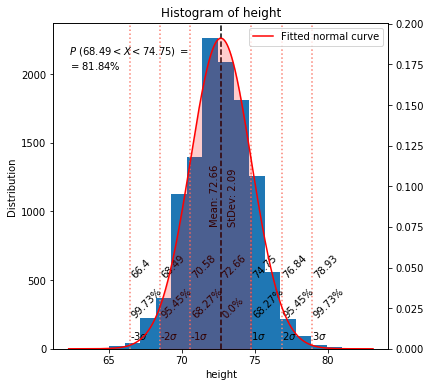

count    11502.000000
mean        72.664785
std          2.086986
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max         81.000000
Name: height, dtype: float64

In [6]:
col = 'height'
fit_norm_dist(df[col], h_bins=15, lab2='from_mean',
              x_between=(68.49, 74.75))

#### Player weight
Since there is a fairly large number of records in the NHL Draft dataset, normal curve appears to be a good fit for player weights.

Using normal distribution, from the total 11,587 records in the Series, 9,485 are expected to have 175.31 < weight < 223.69 

Actual number of records with 175.31 < weight < 223.69: 9,269


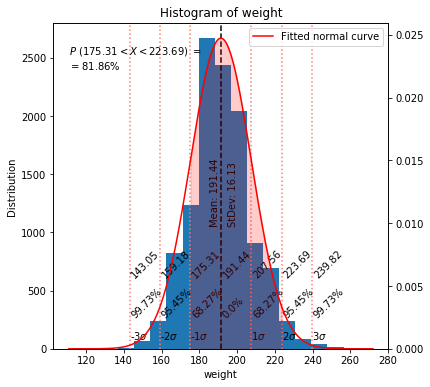

count    11502.000000
mean       191.436378
std         16.127142
min        137.000000
25%        180.000000
50%        190.000000
75%        201.000000
max        265.000000
Name: weight, dtype: float64

In [7]:
col = 'weight'
fit_norm_dist(df[col], h_bins=15, lab2='from_mean',
              mean_lift=0.97, std_lift=1.02,
              x_between=(175.31, 223.69))

#### Goals (from Records API, Most Goals in a Single Season by a Rookie dataset)
Number of goals is not normally distributed (actual distribution could be closer approximated by [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)), and normal curve does not fit the data well.

Using normal distribution, from the total 3,377 records in the Series, 1,153 are expected to have 9.48 < goals < 16.8 

Actual number of records with 9.48 < goals < 16.8: 718


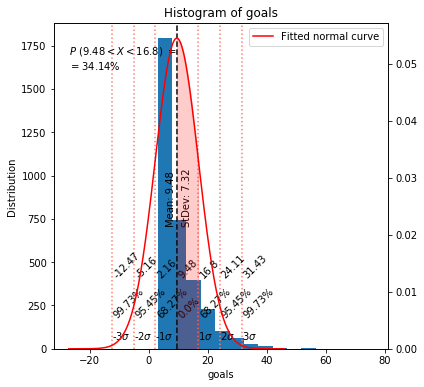

count    3377.000000
mean        9.479123
std         7.317786
min         3.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        76.000000
Name: goals, dtype: float64

In [12]:
col = 'goals'
fit_norm_dist(dfr[col], h_bins=15, lab2='from_mean',
              mean_lift=0.6, std_lift=1.2,
              x_between=(9.48, 16.8))

#### Games played
Actual distribution of the Number of Games Played is not normally distributed (actual distribution appears to be [multimodal](https://en.wikipedia.org/wiki/Multimodal_distribution)), and normal curve does not fit the data well.

Using normal distribution, from the total 3,377 records in the Series, 2,305 are expected to have 30.59 < gamesPlayed < 72.28 

Actual number of records with 30.59 < gamesPlayed < 72.28: 2,002


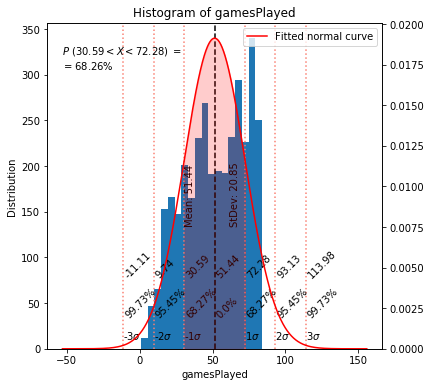

count    3377.000000
mean       51.437074
std        20.847540
min         1.000000
25%        35.000000
50%        53.000000
75%        70.000000
max        84.000000
Name: gamesPlayed, dtype: float64

In [20]:
col = 'gamesPlayed'
fit_norm_dist(dfr[col], h_bins='auto', lab2='from_mean',
              mean_lift=0.6, std_lift=1.2,
              x_between=(30.59, 72.28))

### Normality tests to check if data has a Gaussian distribution
From visually fitting the normal curve and comparing the predicted number of records within range with actual values, Gaussian distribution appears to be a good fit for the distributions of player height and weight. This result appears to be reasonable, given that there are 11'502 records in the NHL draft dataset, which is a fairly high number, as Gaussian distribution gives a good fit.

At the same time, number of goals (from Most Goals in a Single Season by a Rookie from the NHL Records API) and number of games played (same dataset) do not appear to be normally distributed, and thus checks performed above show that Gaussian distribution offers a poor fit to these variables.

To validate these results, normality tests can be conducted to determine if data follows a Gaussian distribution.

Normality Tests include
* Shapiro-Wilk Test
* D’Agostino’s K^2 Test
* Anderson-Darling Test

#### Shapiro-Wilk Test
The Shapiro-Wilk test, proposed in 1965, calculates a $W$ statistic that tests whether a random sample, $x_1,x_2,…,x_n$ comes from (specifically) a normal distribution. Small values of $W$ are evidence of departure from normality.

The $W$ statistic is calculated as follows:
$ W = \large{ \frac { \sum _{i=1}^{n}  a_i x_{(i)}} {\sum_{i=1}^n (x_i - \bar{x} )^2 } } $,
  
where the $x_{(i)}$ are the ordered sample values ($x_{(1)}$ is the smallest) and the $a_i$ are constants generated from the means, variances and covariances of the order statistics of a sample of size n from a normal distribution (see Pearson and Hartley (1972, Table 15).